In [1]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [2]:
import numpy as np
import scipy.io as sio

In [3]:
df = sio.loadmat('snelson1d.mat')
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [6]:
stan_code_matern12_sampler = """
parameters{
    real<lower=1e-6> rho;
    real<lower=1e-6> sigma;
    real omega;
}

transformed parameters{
    real lambda = 1./ rho;
//    real lambda = sqrt(5.)/rho;
}

model {
    rho ~ normal(0, 1.0);
    sigma ~ normal(0, 1.0);
    // for matern 1/2 kernel
   target +=  log(2*square(sigma)*lambda/(square(lambda) + square(omega)));

}

"""

In [7]:
stan_code_matern32_sampler = """
parameters{
    real<lower=1e-6> rho;
    real<lower=1e-6> sigma;
    real omega;
}
transformed parameters{
    real lambda = sqrt(3.)/rho;
}

model {
    rho ~ normal(0, 1.0);
    sigma ~ normal(0, 1.0);

    // for matern 3/2 kernel
    target += log(4*square(sigma)*lambda^(3)/square(square(lambda) + square(omega)));

}

"""

In [8]:
stan_code_matern52_sampler = """
parameters{
    real<lower=1e-6> rho;
    real<lower=1e-6> sigma;
    real omega;
}
transformed parameters{
    real lambda = sqrt(5.)/rho;
}

model {
    rho ~ normal(0, 1.0);
    sigma ~ normal(0, 1.0);

    // for matern 5/2 kernel
    target += log(16*square(sigma)*lambda^(5) / (3*(square(lambda) + square(omega))^3));    
}

"""

In [9]:
stan_matern12_sampler = pystan.StanModel(model_code=stan_code_matern12_sampler)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f81c311e35e528d00602a9c0ed2940d8 NOW.


In [10]:
stan_matern32_sampler = pystan.StanModel(model_code=stan_code_matern32_sampler)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_db1170870ec4588e7a20419a1df278d7 NOW.


In [11]:
stan_matern52_sampler = pystan.StanModel(model_code=stan_code_matern52_sampler)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3fb3e2dc3f5c935fa7888cb8ea27ed76 NOW.


In [12]:
N_star = 25
X_star = np.linspace(-0.5, 6.5, N_star)[:, None]

In [13]:
data = {}

In [14]:
sampler_matern12 = stan_matern12_sampler.sampling(data=data, iter=800, chains=4)

In [15]:
print(sampler_matern12)

Inference for Stan model: anon_model_f81c311e35e528d00602a9c0ed2940d8.
4 chains, each with iter=800; warmup=400; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho      0.86    0.06   0.65   0.03   0.35   0.71   1.26   2.68    132   1.01
sigma    1.58    0.05   0.73   0.35   1.06   1.54   2.05   3.13    211    1.0
omega    6.54    6.47  72.95 -43.64  -1.42   0.04   1.95  90.93    127   1.02
lambda   5.93    1.57  33.67   0.37   0.79    1.4   2.87  33.02    458   1.01
lp__    -3.05     0.3   2.77 -10.57  -4.26  -2.34  -1.06   0.22     86   1.03

Samples were drawn using NUTS at Mon May 14 13:30:20 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [16]:
samples_matern12 = sampler_matern12.extract(permuted=True)

In [17]:
print(list(samples_matern12.keys()))

['rho', 'sigma', 'omega', 'lambda', 'lp__']


In [18]:
sampler_matern32 = stan_matern32_sampler.sampling(data=data, iter=800, chains=4)

In [19]:
sampler_matern52 = stan_matern52_sampler.sampling(data=data, iter=800, chains=4)

In [20]:
samples_matern32 = sampler_matern32.extract(permuted=True)

In [21]:
samples_matern52 = sampler_matern52.extract(permuted=True)

In [22]:
sigma_samples12 = samples_matern12['sigma']
omega_samples12 = samples_matern12['omega']
lambda_samples12 = samples_matern12['lambda']
rho_samples12 = samples_matern12['rho']

In [23]:
sigma_samples32 = samples_matern32['sigma']
omega_samples32 = samples_matern32['omega']
lambda_samples32 = samples_matern32['lambda']
rho_samples32 = samples_matern32['rho']

In [24]:
sigma_samples52 = samples_matern52['sigma']
omega_samples52 = samples_matern52['omega']
lambda_samples52 = samples_matern52['lambda']
rho_samples52 = samples_matern52['rho']

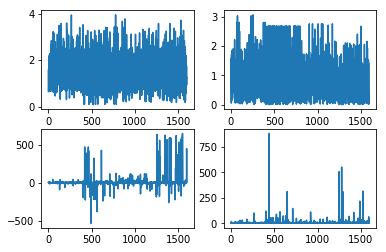

In [25]:
fig, axes = plt.subplots(2,2)
axes[0,0].plot(sigma_samples12)
axes[0,1].plot(rho_samples12)
axes[1,0].plot(omega_samples12)
axes[1,1].plot(lambda_samples12)

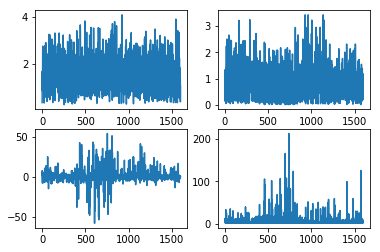

In [28]:
fig, axes = plt.subplots(2,2)
axes[0,0].plot(sigma_samples32)
axes[0,1].plot(rho_samples32)
axes[1,0].plot(omega_samples32)
axes[1,1].plot(lambda_samples32)

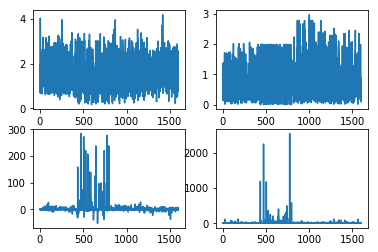

In [29]:
fig, axes = plt.subplots(2,2)
axes[0,0].plot(sigma_samples52)
axes[0,1].plot(rho_samples52)
axes[1,0].plot(omega_samples52)
axes[1,1].plot(lambda_samples52)

In [30]:
omega_matern12 = omega_samples12[::40] 
omega_matern32 = omega_samples32[::40] 
omega_matern52 = omega_samples52[::40]

In [44]:
stan_code_matern = """
functions{
    vector gp_rff_pred_rng(vector x, vector y, vector x_star, matrix A, matrix phi, vector omega, real ps, real sigma, real jitter){

        int N = rows(y);
        int M = rows(omega);
        int N_star = rows(x_star);
        vector[N_star] f_star;
        matrix[N_star, N_star] f_star_cov;

        {
            vector[N_star] f_star_mean;
            matrix[N_star, M] cosfeats_star;
            matrix[N_star, M] sinfeats_star;
            matrix[N_star, M] feats_star; 
            matrix[N_star, 2*M] phi_star;
            matrix[2*M, 2*M]A_inv;
            vector[2*M] A_inv_phi_y;
            matrix[2*M, N_star] A_inv_phi_star;

            vector[2*M]phi_y = phi'*y;

            feats_star = x_star*omega'*ps;

            for(i in 1:N_star){
                 for(j in 1:M){
                     cosfeats_star[i,j] = cos(feats_star[i,j] );
                     sinfeats_star[i,j] = sin(feats_star[i,j] );
                     phi_star[i,j] = cosfeats_star[i,j];
                     phi_star[i,M+j] = sinfeats_star[i,j];
                }
            }

           A_inv = inverse(A);

           A_inv_phi_y = A_inv* phi_y;
#            f_star_mean = phi_star*A_inv_phi_y;
           
           f_star_mean = phi_star*A_inv_phi_y*(2./M);
           A_inv_phi_star = A_inv * phi_star';

           f_star_cov = square(sigma)*phi_star*A_inv_phi_star;
           for(i in 1:N_star){
                f_star[i] = normal_rng(f_star_mean[i], f_star_cov[i,i]);
           }
           
           
        }

       return f_star;
    }
}

data {
    int<lower=1> N;
    int<lower=1> M;
    int<lower=1> N_star;
    vector[N] x;
    vector[N] y;
    vector[M] omega; 
    vector[N_star] x_star;
}

transformed data {
    real jitter = 1e-6;
    real scale;
    vector[N] f_mean = rep_vector(0, N);
    scale = sqrt(2.0/M);

}

parameters{
    vector[M] b1;
    vector[M] b2;
    real<lower=0> ps;
    vector[M] bk;
    real<lower=1e-6> sigma;

}

transformed parameters {
    vector[N] f;
#     matrix[N, N] K;
    matrix[N, M] feats;
    matrix[2*M, 2*M] A;
    matrix[N, 2*M] fullfeats;
    
    { 
        matrix[N, M] cosfeats;
        matrix[N, M] sinfeats;
        vector[N] cosfeats_shift;
        vector[N] sinfeats_shift;
        feats = x * omega' * ps;

         for(i in 1:N){
             for(j in 1:M){
                 cosfeats[i,j] = cos(feats[i,j] );
                 sinfeats[i,j] = sin(feats[i,j] );
                 fullfeats[i,j] = cosfeats[i,j];
                 fullfeats[i,M+j] = sinfeats[i,j];
             }
         }

        cosfeats_shift = cosfeats * b1;
        sinfeats_shift = sinfeats * b2;
        f = (cosfeats_shift + cosfeats_shift)*scale;
        A = fullfeats'*fullfeats*square(scale);
        for(i in 1:2*M){
            A[i,i] = A[i,i] + M*square(sigma);
        }

    }
}

model {
    ps ~ normal(0, 1.0);
    bk ~ normal(0,1);
    b1 ~ normal(0.0, 1.0);
    b2 ~ normal(0.0, 1.0);
    sigma ~ normal(0.0, 0.5);
    
    y ~ normal(f, sigma);
    
}

generated quantities{
    vector[N_star] f_star = gp_rff_pred_rng(x, y, x_star, A, fullfeats, omega, ps, sigma, jitter);
    vector[N_star] y_star;
    for(i in 1:N_star){
        y_star[i] = normal_rng(f_star[i], sigma);
    }

}

"""

In [45]:
stan_model_matern = pystan.StanModel(model_code=stan_code_matern)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9d7e36bc24f1e486fa2c1feaf7b282c4 NOW.


In [33]:
N_star = 25
X_star = np.linspace(-0.5, 6.5, N_star)[:, None]
M = 40

In [34]:
data_matern12 = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':M, 'omega':omega_matern12, 'N_star':N_star, 'x_star':X_star.flatten()}
data_matern32 = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':M, 'omega':omega_matern32, 'N_star':N_star, 'x_star':X_star.flatten()}
data_matern52 = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':M, 'omega':omega_matern52, 'N_star':N_star, 'x_star':X_star.flatten()}

In [36]:
fit_gpr_matern12 = stan_model_matern.sampling(data=data_matern12, iter=800, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [37]:
gpr_matern12_samples = fit_gpr_matern12.extract(permuted=True)

In [46]:
fit_gpr_matern32 = stan_model_matern.sampling(data=data_matern32, iter=800, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [47]:
gpr_matern32_samples = fit_gpr_matern32.extract(permuted=True)

In [60]:
fit_gpr_matern52 = stan_model_matern.sampling(data=data_matern52, iter=800, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [61]:
gpr_matern52_samples = fit_gpr_matern52.extract(permuted=True)

In [62]:
f12 = gpr_matern12_samples['f']

In [63]:
f32 = gpr_matern32_samples['f']

In [64]:
f52 = gpr_matern52_samples['f']

In [65]:
print(gpr_matern12_samples.keys())

odict_keys(['b1', 'b2', 'ps', 'bk', 'sigma', 'f', 'feats', 'A', 'fullfeats', 'f_star', 'y_star', 'lp__'])


In [66]:
f12_25 = np.percentile(f12, 2.5, axis=0)
f12_975 = np.percentile(f12, 97.5, axis=0)
f32_25 = np.percentile(f32, 2.5, axis=0)
f32_975 = np.percentile(f32, 97.5, axis=0)
f52_25 = np.percentile(f52, 2.5, axis=0)
f52_975 = np.percentile(f52, 97.5, axis=0)

####  Confidence Intervals for latent value(f), latent value predictions(f_star), observations(y_star)  for matern 1/2 kernel

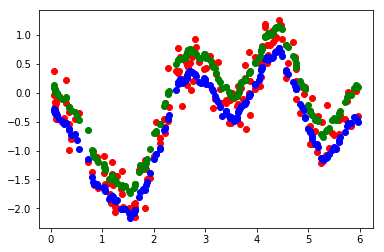

In [67]:
plt.plot(X,Y, 'ro')
plt.plot(X, f12_25, 'bo')
plt.plot(X, f12_975, 'go')

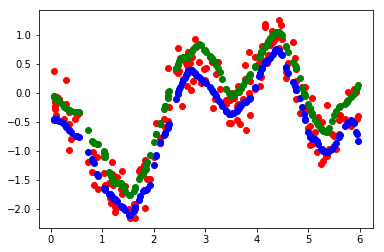

In [68]:
plt.plot(X,Y, 'ro')
plt.plot(X, f32_25, 'bo')
plt.plot(X, f32_975, 'go')

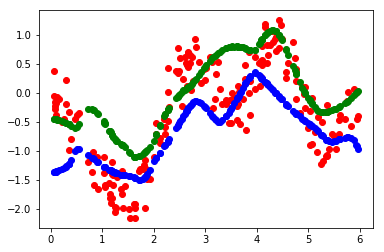

In [69]:
plt.plot(X,Y, 'ro')
plt.plot(X, f52_25, 'bo')
plt.plot(X, f52_975, 'go')

In [133]:
print("Mean difference for f-matern12 between 2.5 and 97.5 percentile: %.3f"%np.mean(f12_975 - f12_25))
print("Mean difference for f-matern32 between 2.5 and 97.5 percentile: %.3f"%np.mean(f32_975 - f32_25))

Mean difference for f-matern12 between 2.5 and 97.5 percentile: 0.571
Mean difference for f-matern32 between 2.5 and 97.5 percentile: 0.457


In [134]:
f12_star = gpr_matern12_samples['f_star']
y12_star = gpr_matern12_samples['y_star']
f32_star = gpr_matern32_samples['f_star']
y32_star = gpr_matern32_samples['y_star']
f52_star = gpr_matern52_samples['f_star']
y52_star = gpr_matern52_samples['y_star']

In [135]:
f12_star_25 = np.percentile(f12_star, 2.5, axis=0)
f12_star_975 = np.percentile(f12_star, 97.5, axis=0)
f32_star_25 = np.percentile(f32_star, 2.5, axis=0)
f32_star_975 = np.percentile(f32_star, 97.5, axis=0)
f52_star_25 = np.percentile(f52_star, 2.5, axis=0)
f52_star_975 = np.percentile(f52_star, 97.5, axis=0)

In [136]:
y12_star_25 = np.percentile(y12_star, 2.5, axis=0)
y12_star_975 = np.percentile(y12_star, 97.5, axis=0)
y32_star_25 = np.percentile(y32_star, 2.5, axis=0)
y32_star_975 = np.percentile(y32_star, 97.5, axis=0)
y52_star_25 = np.percentile(y52_star, 2.5, axis=0)
y52_star_975 = np.percentile(y52_star, 97.5, axis=0)

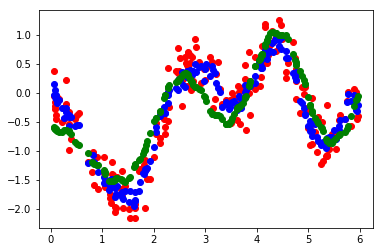

In [138]:
plt.plot(X,Y, 'ro')
plt.plot(X, f12[193], 'bo')
plt.plot(X, f12[338], 'go')

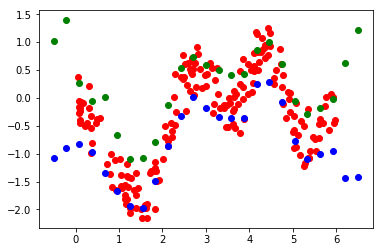

In [139]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, f12_star_25, 'bo')
plt.plot(X_star, f12_star_975, 'go')

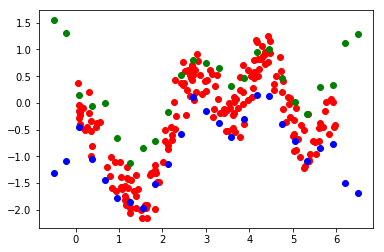

In [140]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, f32_star_25, 'bo')
plt.plot(X_star, f32_star_975, 'go')

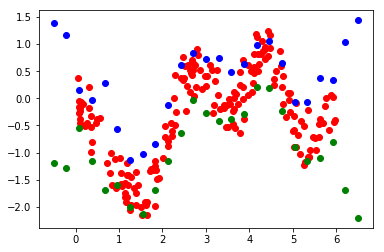

In [150]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, f52_star_25, 'go')
plt.plot(X_star, f52_star_975, 'bo')

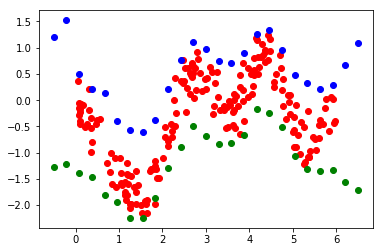

In [142]:
plt.plot(X, Y, 'ro')
plt.plot(X_star, y12_star_25, 'go')
plt.plot(X_star, y12_star_975, 'bo')

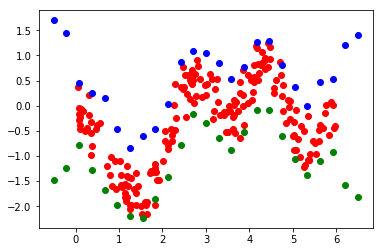

In [143]:
plt.plot(X, Y, 'ro')
plt.plot(X_star, y32_star_25, 'go')
plt.plot(X_star, y32_star_975, 'bo')

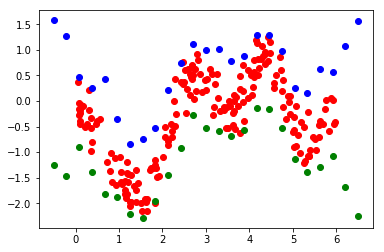

In [144]:
plt.plot(X, Y, 'ro')
plt.plot(X_star, y52_star_25, 'go')
plt.plot(X_star, y52_star_975, 'bo')

In [149]:
print("Mean difference for f_star(latent value predictions)-matern12 between 2.5 and 97.5 percentile: %.3f"%np.mean(f12_star_975*2 - f12_star_25*2))
print("Mean difference for y_star(output predictions)-matern12 between 2.5 and 97.5 percentile: %.3f"%np.mean(y12_star_975*2 - y12_star_25*2))

Mean difference for f_star(latent value predictions)-matern12 between 2.5 and 97.5 percentile: 2.133
Mean difference for y_star(output predictions)-matern12 between 2.5 and 97.5 percentile: 3.517


In [146]:
print("Mean difference for f-matern12 between 2.5 and 97.5 percentile: %.3f"%np.mean(f12_975/10 - f12_25/10))
print("Mean difference for f-matern32 between 2.5 and 97.5 percentile: %.3f"%np.mean(f32_975/10 - f32_25/10))
print("Mean difference for f-matern52 between 2.5 and 97.5 percentile: %.3f"%np.mean(f52_975/10 - f52_25/10))

Mean difference for f-matern12 between 2.5 and 97.5 percentile: 0.057
Mean difference for f-matern32 between 2.5 and 97.5 percentile: 0.046
Mean difference for f-matern52 between 2.5 and 97.5 percentile: 0.051


In [147]:
print("Mean difference for f_star(latent value predictions)-matern32 between 2.5 and 97.5 percentile: %.3f"%np.mean(f32_star_975*2 - f32_star_25*2))
print("Mean difference for y_star(output predictions)-matern32 between 2.5 and 97.5 percentile: %.3f"%np.mean(y32_star_975*2 - y32_star_25*2))

Mean difference for f_star(latent value predictions) between 2.5 and 97.5 percentile: 2.443
Mean difference for y_star(output predictions) between 2.5 and 97.5 percentile: 3.381


In [148]:
print("Mean difference for f_star(latent value predictions)-matern52 between 2.5 and 97.5 percentile: %.3f"%np.mean(f52_star_975*2 - f52_star_25*2))
print("Mean difference for f_star(latent value predictions)=matern52 between 2.5 and 97.5 percentile: %.3f"%np.mean(y52_star_975*2 - y52_star_25*2))

Mean difference for f_star(latent value predictions) between 2.5 and 97.5 percentile: 2.658
Mean difference for f_star(latent value predictions) between 2.5 and 97.5 percentile: 3.588


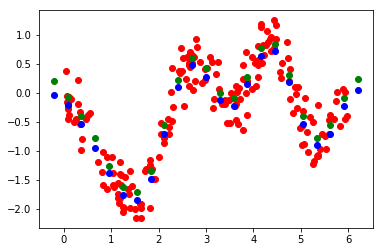

In [72]:
plt.plot(X,Y, 'ro')
plt.plot(X_star[1:-1], y_star_25[1:-1]/10, 'bo')
plt.plot(X_star[1:-1], y_star_975[1:-1]/10, 'go')